# Angular cross correlations
This notebook shows extended examples for how to calculate angular two-point correlators for a variety of projected tracers of the matter fluctuations. These make use of the flexible generalized tracers, halo model, and 2D $P(k,a)$ framework implemented in CCL.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
cosmo = ccl.CosmologyVanillaLCDM()

We will consider 6 different projected quantities:
- Galaxy overdensity
- Cosmic shear
- CMB lensing convergence
- ISW contribution to CMB fluctuations
- tSZ Compton-y fluctuations
- CIB intensity maps

The first step is generating "tracers" for these quantities.

## 1. Tracers
`Tracers` are objects that describe the way in which 2D quantities are related to 3D quantities. They contain, for example, information about the radial kernel defining the projection, any scale-dependent transfer function (e.g. due to different quantities being related through spatial derivatives), and potential time derivatives. The 6 quantities listed above have standard CCL tracers associated with them. It is possible to create custom tracers for other quantities, and you can go as crazy as you want. Check out the [notebook on Generalized Tracers](https://github.com/LSSTDESC/CCLX/blob/master/GeneralizedTracers.ipynb).

In [3]:
z = np.linspace(0, 1, 256)
nz = np.exp(-0.5*((z-0.5)/0.1)**2)
b1 = np.ones_like(z)
A_IA = 0.6*np.ones_like(z)

tracers = {}
# Galaxy clustering
tracers['g'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b1))

# Cosmic shear with intrinsic alignments
tracers['s'] = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), ia_bias=(z, A_IA))

# CMB lensing
tracers['k'] = ccl.CMBLensingTracer(cosmo, z_source=1100)

# ISW
tracers['i'] = ccl.ISWTracer(cosmo)

# tSZ
tracers['y'] = ccl.tSZTracer(cosmo, z_max=3.)

# CIB
tracers['c'] = ccl.CIBTracer(cosmo, z_min=0.05)

Note that we have given galaxies a Gaussian redshift distribution centered about $z=0.5$, a linear bias of 1, and an intrinsic alignment amplitude of 0.6.

## 2. 3D Power spectra
The second ingredient is defining the power spectra that define the cross-correlations between the 3D quantities associated with each of these projected quantities. In the simplest case, these quantities will be linearly (or directly) related to the matter overdensity, in which case CCL's default will be to use the non-linear matter power spectrum it holds internally. Otherwise, you need to specify each $P(k)$ using `Pk2D` objects. Below we show how to do this using the halo model.

Start by defining the range of `k` and scale factor `a` over which you will calculate these power spectra:

In [4]:
lk_arr = np.log(np.geomspace(1E-4, 100, 256))
a_arr = 1./(1+np.linspace(0, 6., 40)[::-1])

Now define the halo model ingredients you'll use (which mass function, halo bias etc. see the [halo model notebook](https://github.com/LSSTDESC/CCLX/blob/master/Halo-model-Pk.ipynb) for more info).

### 2.1 Halo model ingredients

In [5]:
mass_def = ccl.halos.MassDef(200, 'critical')
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mass_def)
cm = ccl.halos.ConcentrationDuffy08(mass_def)
hmc = ccl.halos.HMCalculator(cosmo, hmf, hbf, mass_def)

### 2.2 Halo profiles
Now generate halo profiles for all quantities. We will use an HOD parametrization for galaxy clustering. Check the [documentation](https://ccl.readthedocs.io/en/latest/) for the different parameters you can use to tune these profiles.

In [6]:
profs = {}
# This just defines which of these tracers should be normalized (e.g. overdensities)
norm = {}

# Galaxy clustering
profs['g'] = ccl.halos.HaloProfileHOD(cm)
norm['g'] = True

# Cosmic shear
profs['s'] = ccl.halos.HaloProfileNFW(cm)
norm['s'] = True

# CMB lensing
profs['k'] = ccl.halos.HaloProfileNFW(cm)
norm['k'] = True

# ISW
profs['i'] = ccl.halos.HaloProfileNFW(cm)
norm['i'] = True

# tSZ
profs['y'] = ccl.halos.HaloProfilePressureGNFW(x_out=6)
norm['y'] = False

# CIB
profs['c'] = ccl.halos.HaloProfileCIBShang12(cm, 217)
norm['c'] = False

Note that we're initializing some of these profiles more than once, which is not efficient (something to bear in mind when putting this in a likelihood).

### 2.3 Profile 2-point cumulants
Some of these profiles require custom-made 1-halo 2-point correlators (e.g. accounting for Poisson correlations in the case of HOD). We create a matrix of them here.

In [7]:
tracer_list = list(profs.keys())
profs2pt = {f'{t1}-{t2}': ccl.halos.Profile2pt() for t1 in tracer_list for t2 in tracer_list}
profs2pt['g-g'] = ccl.halos.Profile2ptHOD()
profs2pt['c-c'] = ccl.halos.Profile2ptCIB()

### 2.4 Construct $P(k)$s
Now we put everything together into $P(k)$s for each pair of quantities

In [8]:
pks = {f'{t1}-{t2}': ccl.halos.halomod_Pk2D(cosmo, hmc,
                                            profs[t1],
                                            prof_2pt=profs2pt[f'{t1}-{t2}'],
                                            prof2=profs[t2],
                                            normprof1=norm[t1],
                                            normprof2=norm[t2],
                                            a_arr=a_arr,
                                            lk_arr=lk_arr)
       for t1 in tracer_list for t2 in tracer_list}

Note that we're actually computing some of these $P(k)$s twice, which is inefficient.

## 3 Project $P(k)$s into $C_\ell$s
Now we use `angular_cl` to generate all of the angular power spectra from the tracers and $P(k)$s.

In [9]:
ells = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)
c_ells = {f'{t1}-{t2}': ccl.angular_cl(cosmo, tracers[t1], tracers[t2], ells, p_of_k_a=pks[f'{t1}-{t2}'])
          for t1 in tracer_list for t2 in tracer_list}

Again, computing things twice for cross-correlations. Just bear it in mind!

Let's plot the results:

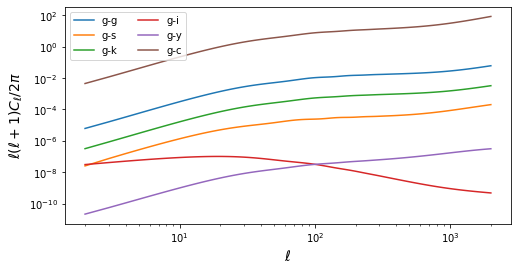

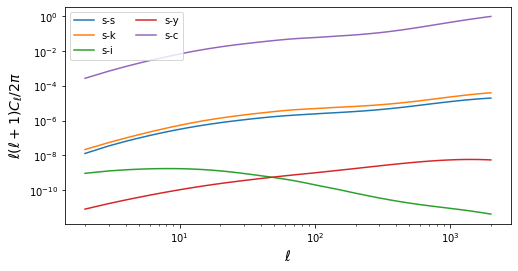

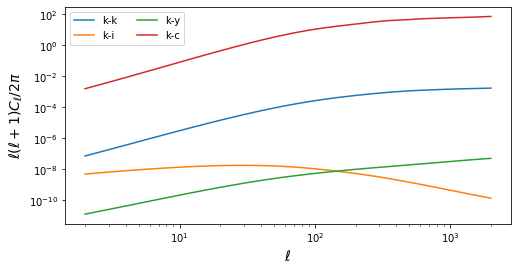

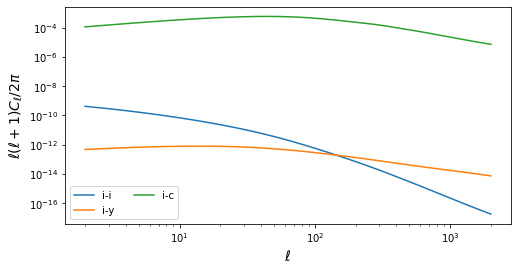

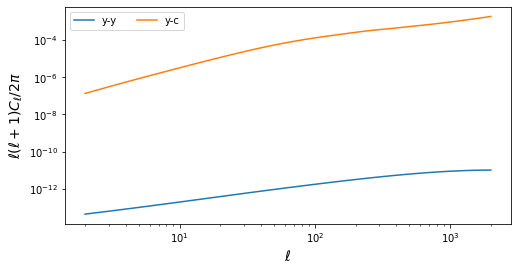

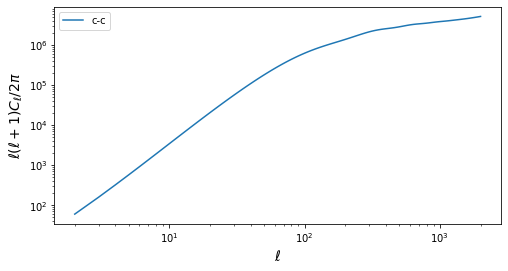

In [10]:
for i1, t1 in enumerate(tracer_list):
    plt.figure(figsize=(8, 4))
    for t2 in tracer_list[i1:]:
        plt.plot(ells, ells*(ells+1)*c_ells[f'{t1}-{t2}']/(2*np.pi), label=f'{t1}-{t2}')
    plt.loglog()
    plt.legend(ncol=2)
    plt.xlabel(r'$\ell$', fontsize=14)
    plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)

This just illustrates how to combine all of these quantities using the halo model. CCL supports other ways to parametrize e.g. galaxy bias or intrinsic alignments. Check out the [notebook on perturbation theory biases](https://github.com/LSSTDESC/CCLX/blob/master/PerturbationTheoryPk.ipynb) to learn how to do that.